In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print('Torch version:', torch.__version__)

Torch version: 2.7.0+cu126


In [4]:
import clip

print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [5]:
model_name = 'ViT-B/16'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load(model_name, device=device)
print('Model loaded:', model_name)
print('Device:', device)
print('Preprocess function:', preprocess)

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(f'Model parameters: {np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}')
print(f'Input resolution: {input_resolution}')
print(f'Context length: {context_length}')
print(f'Vocab size: {vocab_size}')
print(f'Preprocess function: {preprocess}')

Model loaded: ViT-B/16
Device: cuda
Preprocess function: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x72b80791efc0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408
Preprocess function: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x72b80791efc0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [6]:
tokens = clip.tokenize('Hello, world!')
print('Tokens:', tokens)
print('Tokens shape:', tokens.shape)

Tokens: tensor([[49406,  3306,   267,  1002,   256, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)
Tokens shape: torch.Size([1, 77])


Image directory: /home/vmoskov/arkensight/images
Number of images: 5


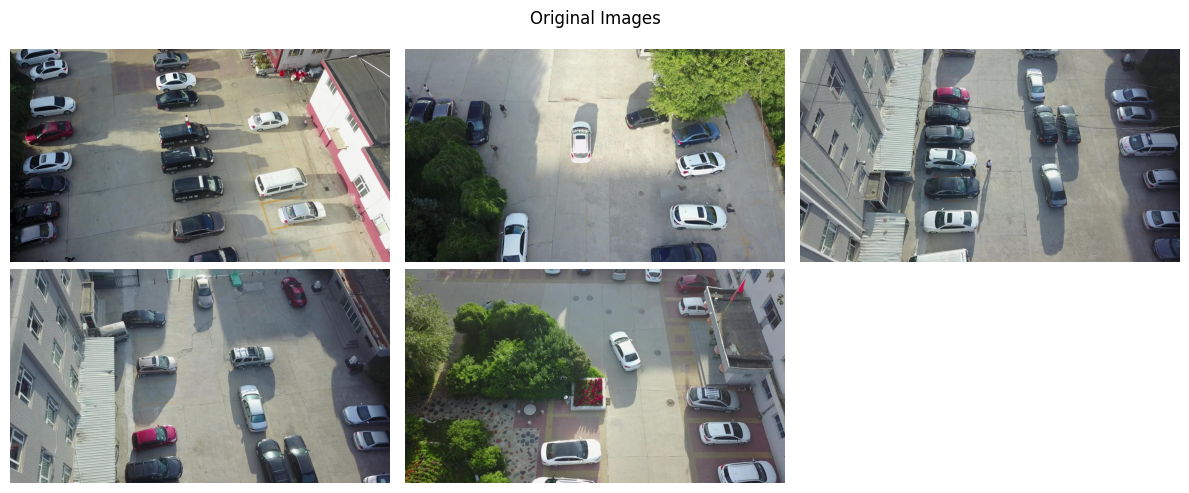

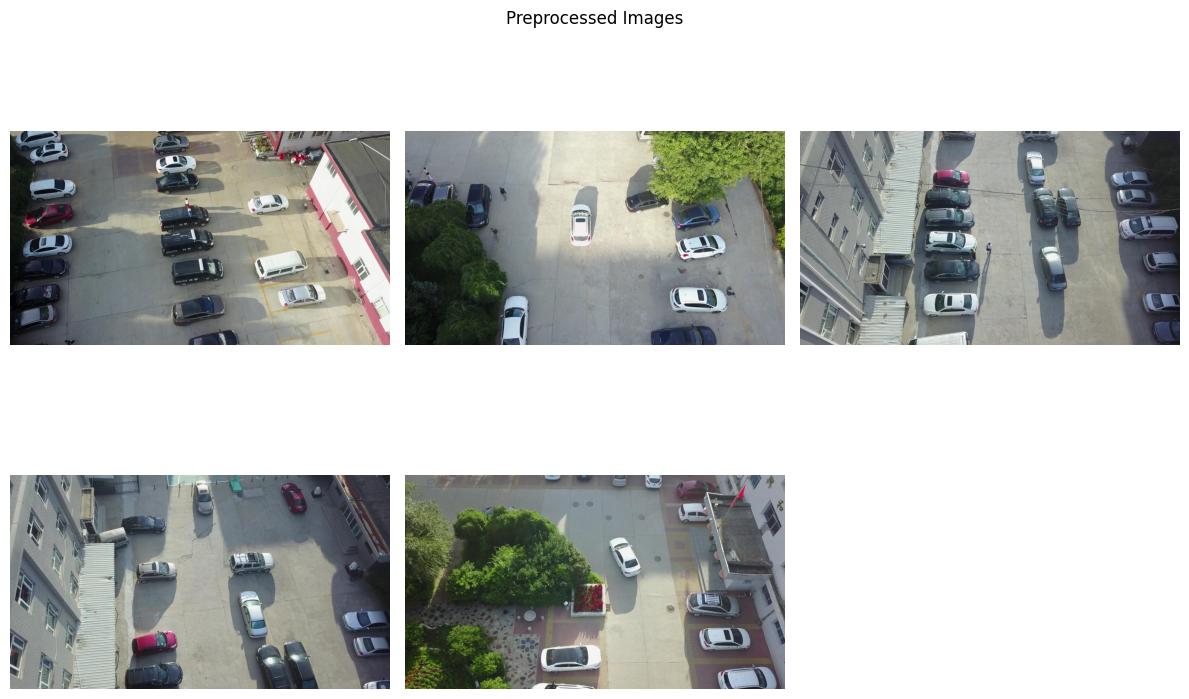

In [ ]:
from pathlib import Path
from PIL import Image

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)  # suppress matplotlib clipping warnings for better readability

img_dir = Path(Path.cwd() / 'images')
print('Image directory:', img_dir)

# load images
img_paths = list(img_dir.glob('*.jpg'))
print(f'Number of images: {len(img_paths)}')

original_images = []
images = []

for img_path in img_paths:
    image = Image.open(img_path)
    original_images.append(image)
    # turn to tensor and append to list
    images.append(torch.tensor(np.array(image)).permute(2, 0, 1))

# show original images
plt.figure(figsize=(12, 5))
plt.suptitle('Original Images')
for i, img in enumerate(original_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# show preprocessed images
plt.figure(figsize=(12, 8))
plt.suptitle('Preprocessed Images')

for i, img in enumerate(images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()


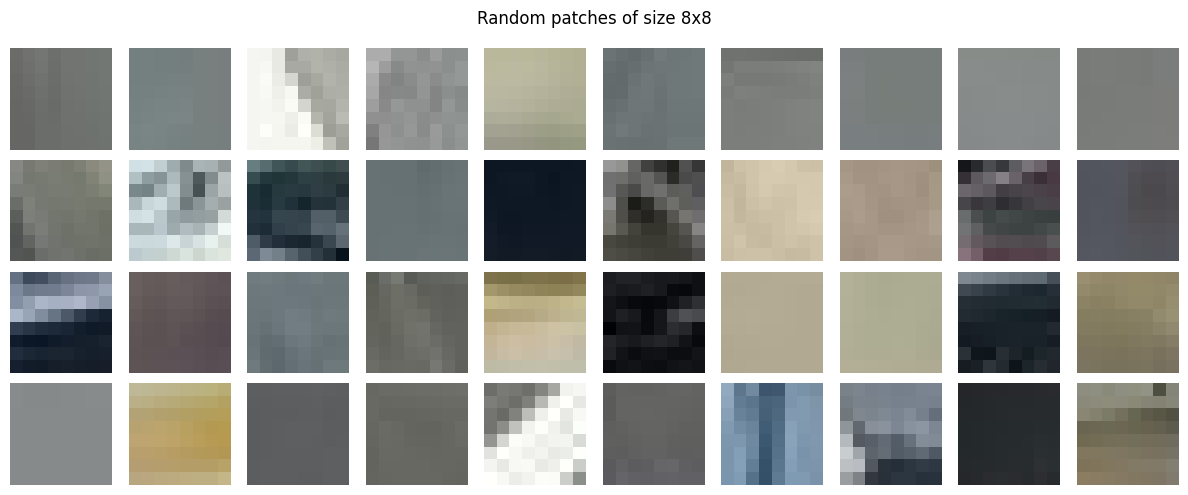

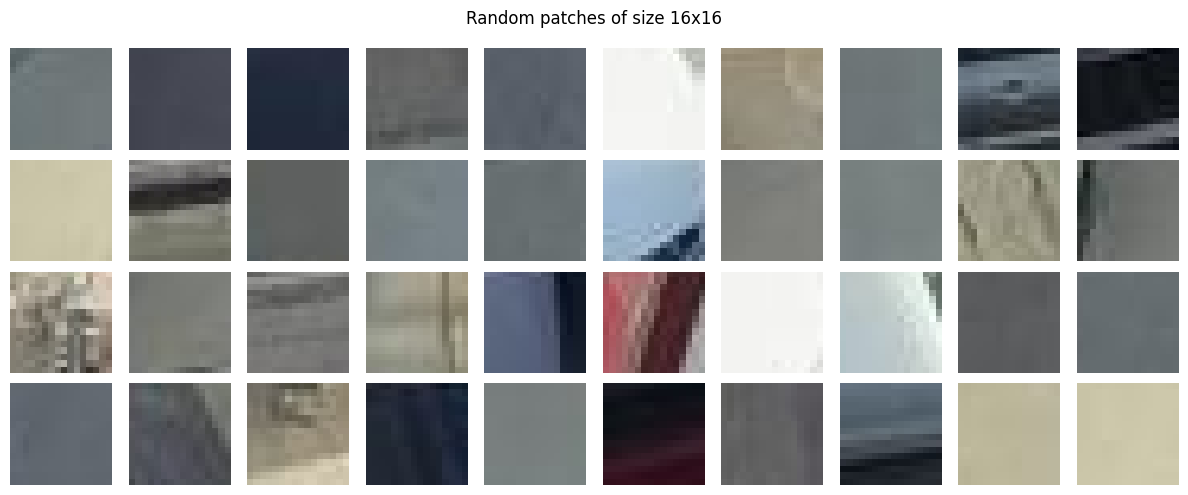

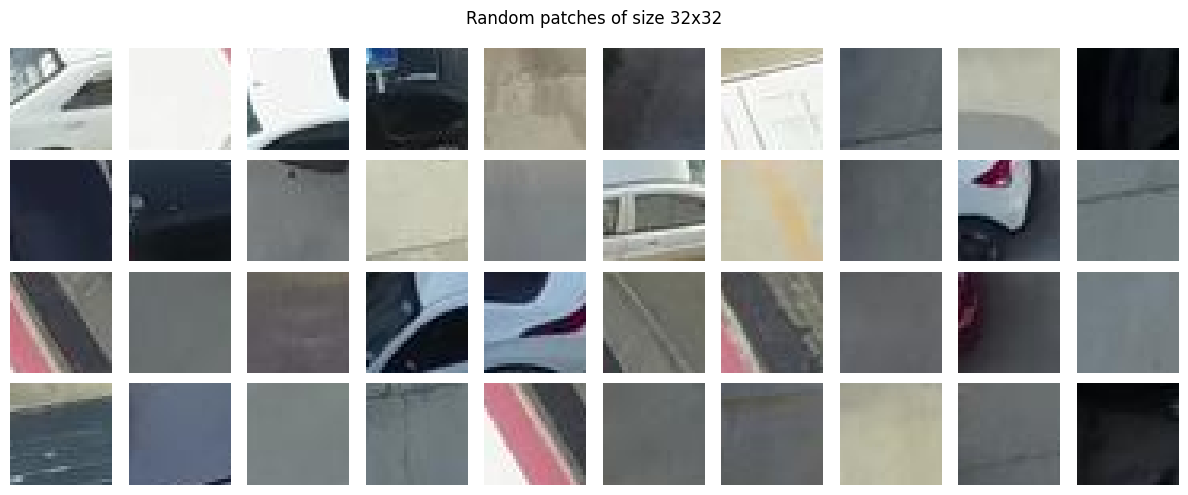

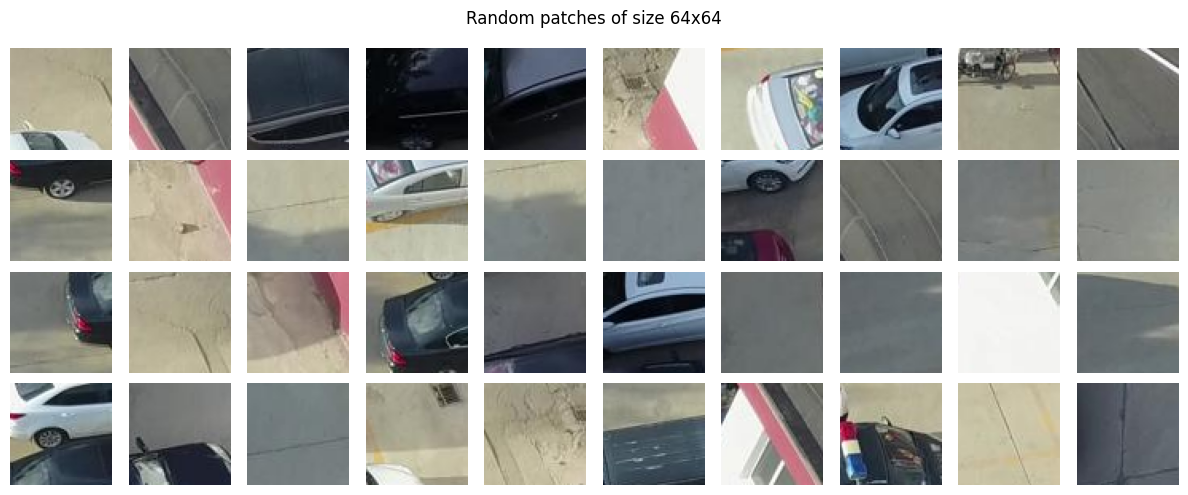

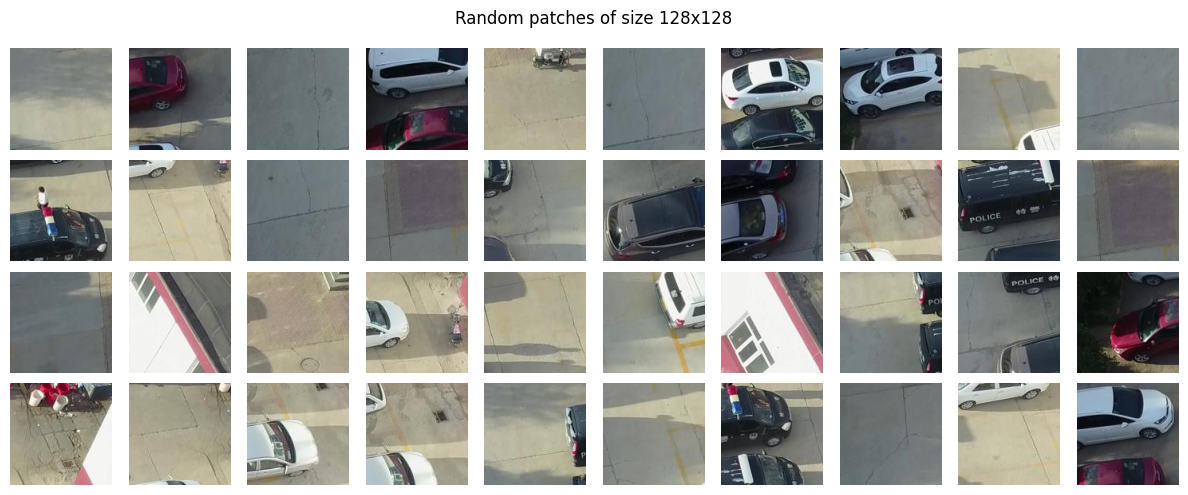

In [8]:

# test with different patch sizes
# only on first image
img = images[0]
for patch_size in [8, 16, 32, 64, 128]:
    # show 40 random patches
    patches = []
    for _ in range(40):
        x = np.random.randint(0, img.shape[1] - patch_size)
        y = np.random.randint(0, img.shape[2] - patch_size)
        patch = img[:, x:x + patch_size, y:y + patch_size]
        patches.append(patch)
    patches = torch.stack(patches)
    patches = patches.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Random patches of size {patch_size}x{patch_size}')
    for i, patch in enumerate(patches):
        plt.subplot(4, 10, i + 1)
        plt.imshow(patch)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Patches with sizes 128x128 and 64x64 are definitely too large for car detection, since they contain too much background information. Furthermore, patches with sizes 32x32 capture almost the entire car, which is not ideal for training a detector since we want to slide the window over the image taking multiple patches at once into consideration to have a finer granulation of the image. It could be useful to detect cars on a bigger scale. We fall back to the 16x16 patches.

Patches shape: torch.Size([1, 9, 16, 3, 85, 85])


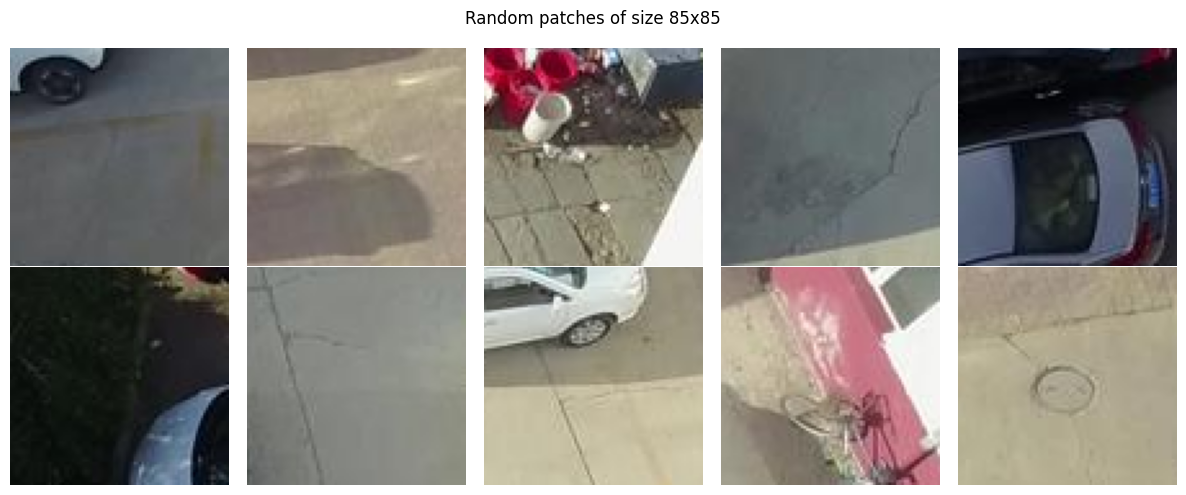

In [9]:
import einops

image_inputs = torch.stack(images).to(device)

# test the model on the first image only
img = image_inputs[0]

# patchify the image
def patchify(x, patch_size):
    # x: (B, C, H, W)
    # patch_size: int
    # return: (B, num_patches, C, patch_size, patch_size)
    # channel last
    x = einops.rearrange(x, 'b c h w -> b h w c')
    # unfold
    x = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    return x


patch_size = 85
patches = patchify(img.unsqueeze(0), patch_size)
print('Patches shape:', patches.shape)
# show 10 random patches
plt.figure(figsize=(12, 5))
plt.suptitle(f'Random patches of size {patch_size}x{patch_size}')
for i in range(10):
    x = np.random.randint(0, patches.shape[1] - 1)
    y = np.random.randint(0, patches.shape[2] - 1)
    plt.subplot(2, 5, i + 1)
    plt.imshow(patches[0, x, y].permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
classes = ['car']
text_input = clip.tokenize([f'a photo of a {c}' for c in classes]).to(device)

scores = torch.zeros(patches.shape[1], patches.shape[2]).to(device)
runs = torch.ones(patches.shape[1], patches.shape[2]).to(device)

window_size = 2
stride = 1

for Y in range(0, patches.shape[1] - window_size + 1, stride):  # slide top to bottom
    for X in range(0, patches.shape[2] - window_size + 1, stride):  # slide left to right
        window = torch.zeros(patch_size * window_size, patch_size * window_size, 3, dtype=torch.int32)
        patch_pool = patches[0, Y:Y + window_size, X:X + window_size]
        for y in range(window_size):
            for x in range(window_size):
                window[y * patch_size:(y + 1) * patch_size, x * patch_size:(x + 1) * patch_size] = patch_pool[y, x].permute(1, 2, 0)
        
        # read window to PIL image
        window = Image.fromarray(window.numpy().astype(np.uint8))
        window = preprocess(window).unsqueeze(0).to(device)  # preprocess window
        with torch.no_grad():
            logits_per_image, logits_per_text = model(window, text_input)
            score = logits_per_image

        scores[Y:Y + window_size, X:X + window_size] += score
        runs[Y:Y + window_size, X:X + window_size] += 1

# normalize scores
scores /= runs
scores = torch.clamp(scores-scores.mean(), 0, scores.max())
scores = (scores - scores.min()) / (scores.max() - scores.min())

print('Scores shape:', scores.shape)
print('Patches shape:', patches.shape)


Scores shape: torch.Size([9, 16])
Patches shape: torch.Size([1, 9, 16, 3, 85, 85])


In [11]:
adjusted_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
print('Adjusted patches shape:', adjusted_patches.shape)

Adjusted patches shape: torch.Size([85, 85, 3, 9, 16])


In [12]:
adjusted_patches = adjusted_patches.to(torch.float32)
adjusted_patches *= scores
adjusted_patches = adjusted_patches.to(torch.int32)

adjusted_patches = adjusted_patches.permute(3, 4, 2, 0, 1)  # rotate patches to visualize
print('Adjusted patches shape:', adjusted_patches.shape)

Adjusted patches shape: torch.Size([9, 16, 3, 85, 85])


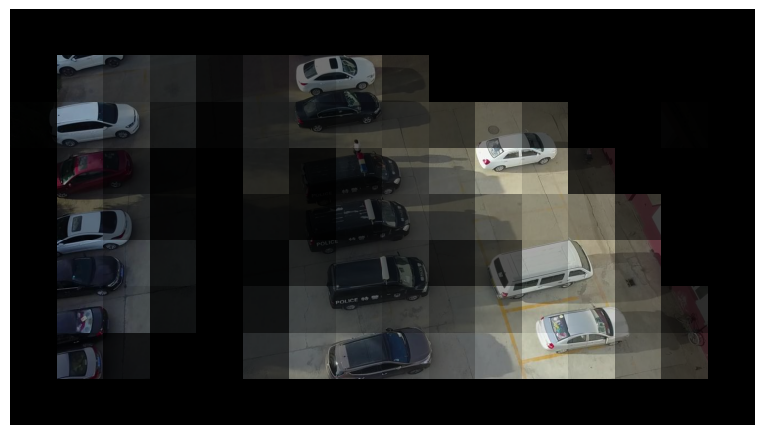

In [13]:
Y = adjusted_patches.shape[0]
X = adjusted_patches.shape[1]

fig, ax = plt.subplots(Y, X, figsize=(X*.6, Y*.6))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adjusted_patches[y, x].permute(1, 2, 0).cpu().numpy())
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()